In [1]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)

# === 4. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


Preparing harmonized SOC stock (0–30 cm) according to FAO guidelines, including coarse fragment corrections, spline harmonization, uncertainty propagation, and visualization.

In [3]:
# dealing with mapping thick_contents_count to a course fragment percentage

import pandas as pd
import numpy as np
import re

# Base mapping: Portuguese terms → (low, high, midpoint)
base_classes = {
    "rarissimo": (0, 2, 1),
    "acidental": (0, 2, 1),
    "raro": (0, 5, 2.5),
    "pouco": (0, 10, 5),
    "algum": (0, 10, 5),
    "bastante": (10, 25, 17.5),
    "muito": (25, 45, 35),
    "abundante": (45, 55, 50),
    "abundantes": (45, 55, 50),
    "abundantissimo": (80, 90, 85),
    "predominio": (55, 80, 67.5),
    "ligeiro predominio": (45, 55, 50),
    "partes sensivelmente iguais": (45, 55, 50),
}

def parse_frag_label(label):
    if pd.isna(label) or str(label).strip() == "" or label.strip() == "0":
        return (0, 0, 0)

    s = str(label).lower()
    # collect all known terms in string
    matches = [v for k, v in base_classes.items() if k in s]

    if not matches:
        return (np.nan, np.nan, np.nan)

    lows = [m[0] for m in matches]
    highs = [m[1] for m in matches]

    low, high = min(lows), max(highs)
    mid = (low + high) / 2
    return (low, high, mid)

# Example: apply to your dataframe
merged_final[["frag_low", "frag_high", "frag_mid"]] = (
    merged_final["thick_contents_count"]
    .apply(parse_frag_label)
    .apply(pd.Series)
)


/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_31902/3881833484.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile['bd_corrected'] = profile['bulk_density'] * (1 - profile['frag_mid']/100)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_31902/3881833484.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile['thickness_m'] = (profile['lower_depth'] - profile['upper_depth']) / 100
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_31902/3881833484.py:91: SettingW

   profile  soc_harmonized_percent  soc_stock_0_30cm  flag_negative_original
0   100_56                0.723829          2.527514                   False
1   100_58                1.229639          4.255625                   False
2   100_59                0.755000          0.000000                   False
4   100_63                0.353306          1.643339                   False
6  101A_58                0.767291          2.795672                   False
count    930.000000
mean       2.815592
std        2.548913
min        0.000000
25%        1.376555
50%        2.235260
75%        3.534686
max       35.253144
Name: soc_stock_0_30cm, dtype: float64


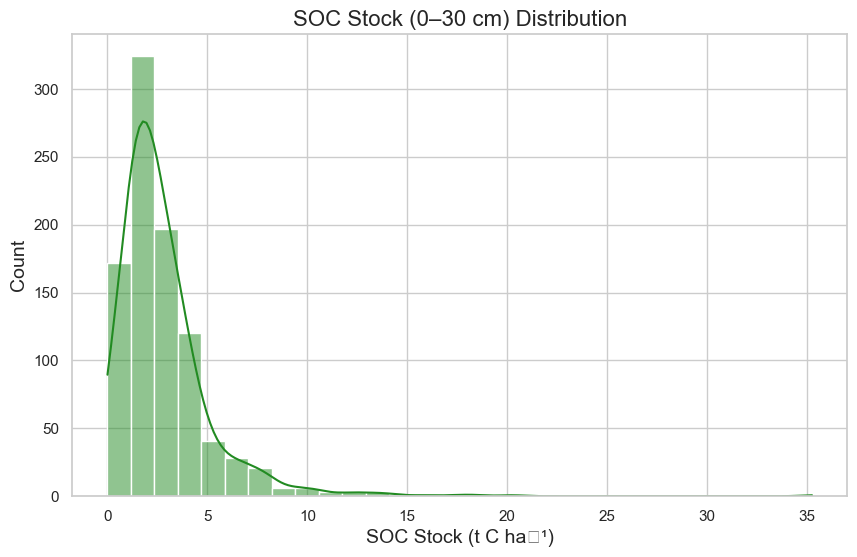

In [8]:
# 0) Imports
# ----------------------------------------
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ------------------------------
# Suppress minor spline warnings
# ------------------------------
warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------
# 1) Specify dataset
# ------------------------------
SOC_dataset = merged_final[['site_info_id', 'analysis_id', 'profile',
                            'upper_depth', 'lower_depth', 'organic_carbon',
                            'X_coord', 'Y_coord', 'bulk_density',
                            'frag_mid']].copy()  # only use mid CF for horizon correction

# Harmonize organic carbon units (percent)
SOC_dataset["soc_percent"] = SOC_dataset["organic_carbon"].apply(
    lambda x: x/10 if x > 50 else x
)

# ------------------------------
# 2) Mass-preserving spline for SOC only
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        return values[0]
    elif n == 2:
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # Compute midpoints and sort
    midpoints = (depth_top + depth_bottom) / 2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    k = min(3, len(values)-1)
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# 3) Harmonize profiles and calculate SOC stock
# ------------------------------
profiles = SOC_dataset['profile'].unique()
harmonized_list = []

for pid in profiles:
    profile = SOC_dataset[SOC_dataset['profile'] == pid]
    
    if profile['soc_percent'].isna().all():
        continue
    
    # Harmonize SOC only (0–30 cm)
    soc_h = fit_mpspline(profile['upper_depth'], profile['lower_depth'], 
                          profile['soc_percent'], lam=1.0, target_depths=[0,30])
    
    # Horizon-level BD correction
    profile['bd_corrected'] = profile['bulk_density'] * (1 - profile['frag_mid']/100)
    
    # Horizon thickness (m)
    profile['thickness_m'] = (profile['lower_depth'] - profile['upper_depth']) / 100
    
    # Horizon SOC stock (Mg C ha-1)
    profile['soc_stock_horizon'] = profile['bd_corrected'] * profile['thickness_m'] * profile['soc_percent'] * 10
    
    # Total 0–30 cm SOC stock
    soc_stock_0_30 = profile[profile['lower_depth'] <= 30]['soc_stock_horizon'].sum()
    
    # Clip negative SOC to zero
    soc_stock_0_30_clipped = max(soc_stock_0_30, 0)
    
    # Flag for review if original SOC was negative
    flag_negative = soc_stock_0_30 < 0
    
    harmonized_list.append({
        'profile': pid,
        'soc_harmonized_percent': soc_h,
        'soc_stock_0_30cm': soc_stock_0_30_clipped,
        'flag_negative_original': flag_negative
    })

# ------------------------------
# 4) Create final dataframe
# ------------------------------
harmonized_df = pd.DataFrame(harmonized_list)
harmonized_df.dropna(subset=['soc_harmonized_percent'], inplace=True)

# Preview
print(harmonized_df.head())

print(harmonized_df['soc_stock_0_30cm'].describe())

# ----------------------------------------
# 6) Histogram of SOC stock
# ----------------------------------------
plt.figure(figsize=(10,6))
sns.histplot(harmonized_df['soc_stock_0_30cm'], bins=30, kde=True, color='forestgreen')
plt.title('SOC Stock (0–30 cm) Distribution', fontsize=16)
plt.xlabel('SOC Stock (t C ha⁻¹)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# ----------------------------------------
# 7) Optional: save harmonized dataset
# ----------------------------------------
# harmonized_df.to_csv("harmonized_soc_0_30cm.csv", index=False)
